In this task I trained a convolutional neural networks for classifing numbers in MNIST dataset, the architecture is the following:

1. Input, (n_batch, height, width, n_channels) - one channel grayscale image or three channel (RGB) image
2. Convolutional layer, 5x5 filters, 6 output channels, no padding, ReLU activation
3. Pooling layer, 2x2 max pooling, no padding
4. Convolutional layer, 5x5 filters, 16 output channels, no padding, ReLU activation
5. Pooling layer, 2x2 max pooling, no padding
6. Dense (fully connected layer), 120 hidden units, ReLU activation
7. Dense (fully connected layer), 84 hidden units, ReLU activation
8. Dense (fully connected layer), 10 hidden units (for 10 classes), no activation
9. Softmax 


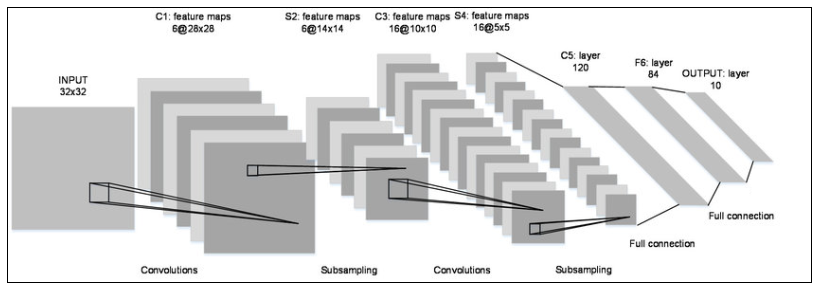

In [91]:
%matplotlib inline

import numpy as np
import tensorflow as tf

n_batch = 4;
n_classes = 10;

tf.reset_default_graph()

# two placeholders for the input and the target
X = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
target = tf.placeholder(tf.float32, shape=[n_batch, n_classes])

conv1 = tf.layers.conv2d(inputs=X, filters=6, kernel_size=(5, 5), activation=tf.nn.relu, name="conv1")
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=(2, 2), strides=(2, 2), padding="valid", name="pool1")

conv2 = tf.layers.conv2d(inputs=pool1, filters=16, kernel_size=(5, 5), activation=tf.nn.relu, name="conv2")
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=(2, 2), strides=(2, 2), padding="valid", name="pool2")

flatten1 = tf.contrib.layers.flatten(pool2)

dense1 = tf.layers.dense(inputs=flatten1, units=120, activation=tf.nn.relu, name="dense1")
dense2 = tf.layers.dense(inputs=dense1, units=84, activation=tf.nn.relu, name="dense2")
dense3 = tf.layers.dense(inputs=dense2, units=10, name="dense3")

p = tf.nn.softmax(dense3);
print(target)
correct_pred = tf.equal(tf.cast(tf.argmax(p, axis=1), "int64"), tf.argmax(tf.cast(target, "int64"), axis=1))
print(correct_pred)
# reduction operations like mean and sum are done in numpy style
acc = tf.reduce_sum(tf.cast(correct_pred, "float"))



cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=dense3, labels=target)
loss = tf.reduce_mean(cross_entropy)



train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

Tensor("pool2/MaxPool:0", shape=(?, 4, 4, 16), dtype=float32)
Tensor("Flatten/flatten/Reshape:0", shape=(?, 256), dtype=float32)
Tensor("Placeholder_1:0", shape=(4, 10), dtype=float32)
Tensor("Equal:0", shape=(4,), dtype=bool)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


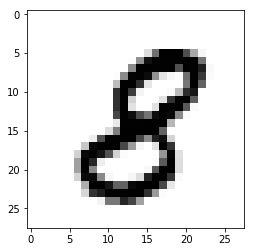

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline
# import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# check MNIST training images matrix data
sample_img = mnist.train.images[5].reshape(28, 28)
sample_img

# plot the image
plt.imshow(sample_img).set_cmap('Greys')

In [79]:
# train set
X_train = mnist.train.images
y_train = mnist.train.labels
print(X_train.shape)
# test set
X_test = mnist.test.images
y_test = mnist.test.labels

(55000, 784)


In [80]:
def generate_minibatches(X_train, n_batch):
    indices = np.arange(len(X_train))
    np.random.shuffle(indices)
    for start_indx in range(0, len(X_train) - n_batch + 1, n_batch):
        batch_indices = indices[start_indx:start_indx+n_batch]
        yield batch_indices

In [82]:
n_train = X_train.shape[0]
X_train = X_train.reshape((n_train,28, 28, 1))
rng_minibatches = n_train/4
n_test = X_test.shape[0]
X_test = X_test.reshape((n_test,28, 28, 1))
rng_minibatches_test = n_test/4
# define a TF session
with tf.Session() as sess:
    # initialize the variables
    sess.run(tf.global_variables_initializer())    
    loss_train_epoch = {}
    for i_epoch in range(0,5):
        loss_train = 0
        acc_train = 0
        for bacth_indices in generate_minibatches(X_train, 4):
            X_train_minibatch = X_train[bacth_indices]
            y_train_minibatch = y_train[bacth_indices]
            [loss_val,acc_val, p_val] = sess.run([los,acc, p], feed_dict={X:X_train_minibatch, target:y_train_minibatch})
            train_step.run(feed_dict={X: X_train_minibatch, target: y_train_minibatch})
            loss_train += loss_val
            acc_train += acc_val    
        loss_train_epoch[i_epoch] = loss_train/rng_minibatches
        print("epoch {},  train loss: {:f}, train acc: {:f}".format(i_epoch, loss_train / rng_minibatches, acc_train / n_train*100))
    loss_test = 0
    acc_test = 0
    loss_test_epoch = {}
    for bacth_indices in generate_minibatches(X_test, 4):
            X_train_minibatch = X_test[bacth_indices]
            y_train_minibatch = y_test[bacth_indices]
            [loss_val,acc_val, p_val] = sess.run([los,acc, p], feed_dict={X:X_train_minibatch, target:y_train_minibatch})
            train_step.run(feed_dict={X: X_train_minibatch, target: y_train_minibatch})
            loss_test += loss_val
            acc_test += acc_val    
    print("test loss: {:f}, test acc: {:f}".format(loss_test / rng_minibatches_test, acc_test / n_test*100))
    

epoch 0,  train loss: 0.142849, train acc: 95.656364
epoch 1,  train loss: 0.067463, train acc: 98.020000
epoch 2,  train loss: 0.054705, train acc: 98.429091
epoch 3,  train loss: 0.046260, train acc: 98.630909
epoch 4,  train loss: 0.043660, train acc: 98.781818
test loss: 0.059960, test acc: 98.450000


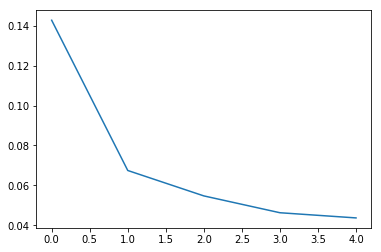

In [86]:
plt.plot(loss_train_epoch.keys(), loss_train_epoch.values())
plt.show()